In [33]:
import os
import zipfile
import pandas as pd
import numpy as np
import re
from io import BytesIO
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta
from joblib import Parallel, delayed

In [4]:

# folder_path = '2023'
# output_data = []

# for file in sorted(os.listdir(folder_path)):
#     if not file.endswith('.zip'):
#         continue

#     date_str = file.replace('.zip', '')  
#     zip_path = os.path.join(folder_path, file)

#     with zipfile.ZipFile(zip_path, 'r') as zip_file:
#         for inner_file in zip_file.namelist():
#             if inner_file.startswith('rb') and inner_file.endswith('.csv'):
#                 with zip_file.open(inner_file) as f:
#                     try:
#                         df = pd.read_csv(f, low_memory=False)
#                         df['date'] = date_str
#                         df['contract'] = inner_file.replace('.csv', '')
#                         output_data.append(df)
#                     except Exception as e:
#                         print(f' {inner_file}  {date_str}: {e}')

# # merge all tick data
# rb_df = pd.concat(output_data, ignore_index=True)

# # Save compressed Parquet file
# rb_df.to_parquet('rb_tick_2023.parquet', index=False, compression='snappy')


In [5]:
df = pd.read_parquet("rb_tick_2023.parquet")
df

,TradingDay,InstrumentID,UpdateTime,UpdateMillisec,LastPrice,Volume,BidPrice1,BidVolume1,AskPrice1,AskVolume1,AveragePrice,Turnover,OpenInterest,date,contract
0,20230103,rb2301,06:59:40,500,4140.0,0,0.0,0,0.0,0,0.0,0.0,42386.0,20230103,rb2301
1,20230103,rb2301,08:59:00,500,4134.0,900,4080.0,60,4135.0,30,41340.0,37206000.0,41486.0,20230103,rb2301
2,20230103,rb2301,09:00:00,500,4134.0,900,4051.0,60,4135.0,30,41340.0,37206000.0,41486.0,20230103,rb2301
3,20230103,rb2301,09:00:01,0,4134.0,900,4052.0,30,4135.0,30,41340.0,37206000.0,41486.0,20230103,rb2301
4,20230103,rb2301,09:00:02,0,4134.0,900,4051.0,60,4135.0,30,41340.0,37206000.0,41486.0,20230103,rb2301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43219171,20231229,rb2412,14:59:26,500,3937.0,75,3926.0,1,3942.0,1,39490.8,2961810.0,89.0,20231229,rb2412
43219172,20231229,rb2412,14:59:28,500,3937.0,75,3926.0,1,3942.0,2,39490.8,2961810.0,89.0,20231229,rb2412
43219173,20231229,rb2412,14:59:32,0,3937.0,75,3926.0,1,3942.0,1,39490.8,2961810.0,89.0,20231229,rb2412
43219174,20231229,rb2412,14:59:59,0,3937.0,75,3920.0,7,3942.0,1,39490.8,2961810.0,89.0,20231229,rb2412


# 筛选主力合约

In [6]:
def get_rb_expiry(instr_id):
    ym = instr_id[-4:]  # extract“2405”
    year = 2000 + int(ym[:2])
    month = int(ym[2:])
    expiry = datetime(year, month, 15)

    # move to next weekday if 15th is weekend
    while expiry.weekday() >= 5:  # 5=Saturday, 6=Sunday
        expiry += timedelta(days=1)
    return expiry


In [7]:
df['expiry'] = df['InstrumentID'].apply(get_rb_expiry)
df.head()

,TradingDay,InstrumentID,UpdateTime,UpdateMillisec,LastPrice,Volume,BidPrice1,BidVolume1,AskPrice1,AskVolume1,AveragePrice,Turnover,OpenInterest,date,contract,expiry
0,20230103,rb2301,06:59:40,500,4140.0,0,0.0,0,0.0,0,0.0,0.0,42386.0,20230103,rb2301,2023-01-16
1,20230103,rb2301,08:59:00,500,4134.0,900,4080.0,60,4135.0,30,41340.0,37206000.0,41486.0,20230103,rb2301,2023-01-16
2,20230103,rb2301,09:00:00,500,4134.0,900,4051.0,60,4135.0,30,41340.0,37206000.0,41486.0,20230103,rb2301,2023-01-16
3,20230103,rb2301,09:00:01,0,4134.0,900,4052.0,30,4135.0,30,41340.0,37206000.0,41486.0,20230103,rb2301,2023-01-16
4,20230103,rb2301,09:00:02,0,4134.0,900,4051.0,60,4135.0,30,41340.0,37206000.0,41486.0,20230103,rb2301,2023-01-16


In [8]:
df['TradingDay'] = pd.to_datetime(df['TradingDay'], format='%Y%m%d')

# volume and sum
daily_liquidity = df.groupby(['TradingDay', 'InstrumentID']).agg(
    total_volume=('Volume', 'sum'),
    avg_open_interest=('OpenInterest', 'mean')
).reset_index()

# scores of volume and sum
daily_liquidity['liquidity_score'] = (
    0.7 * daily_liquidity['total_volume'] / daily_liquidity['total_volume'].max() +
    0.3 * daily_liquidity['avg_open_interest'] / daily_liquidity['avg_open_interest'].max()
)

# top 2
daily_top2 = daily_liquidity.groupby('TradingDay').apply(
    lambda x: x.nlargest(2, 'liquidity_score')['InstrumentID'].tolist()
).reset_index(name='top_contracts')

In [9]:
daily_liquidity

,TradingDay,InstrumentID,total_volume,avg_open_interest,liquidity_score
0,2023-01-03,rb2301,7312306,3.886176e+04,0.005565
1,2023-01-03,rb2302,6142467,1.465538e+04,0.002136
2,2023-01-03,rb2303,66447630,9.253391e+04,0.013797
3,2023-01-03,rb2304,39611876,7.356411e+04,0.010822
4,2023-01-03,rb2305,23524517795,1.891381e+06,0.529019
...,...,...,...,...,...
2899,2023-12-29,rb2408,810289,2.499732e+04,0.003536
2900,2023-12-29,rb2409,992385,2.528374e+04,0.003579
2901,2023-12-29,rb2410,96446636,8.841994e+04,0.013551
2902,2023-12-29,rb2411,45021,3.909381e+03,0.000552


In [10]:
daily_top2

,TradingDay,top_contracts
0,2023-01-03,"[rb2305, rb2310]"
1,2023-01-04,"[rb2305, rb2306]"
2,2023-01-05,"[rb2305, rb2306]"
3,2023-01-06,"[rb2305, rb2306]"
4,2023-01-09,"[rb2305, rb2306]"
...,...,...
237,2023-12-25,"[rb2405, rb2403]"
238,2023-12-26,"[rb2405, rb2403]"
239,2023-12-27,"[rb2405, rb2403]"
240,2023-12-28,"[rb2405, rb2403]"


In [11]:
#Exclude contracts in the delivery month

# Calculate the remaining days to contract maturity
df['days_to_expiry'] = (df['expiry'] - pd.to_datetime(df['TradingDay'])).dt.days

# Filtering rule: contracts with more than 15 days to maturity
df = df[df['days_to_expiry'] > 15]

In [12]:
df

,TradingDay,InstrumentID,UpdateTime,UpdateMillisec,LastPrice,Volume,BidPrice1,BidVolume1,AskPrice1,AskVolume1,AveragePrice,Turnover,OpenInterest,date,contract,expiry,days_to_expiry
1684,2023-01-03,rb2302,06:59:40,500,4033.0,0,0.0,0,0.0,0,0.00,0.0,15251.0,20230103,rb2302,2023-02-15,43
1685,2023-01-03,rb2302,08:59:00,500,4033.0,500,4030.0,1,4050.0,10,40330.00,20165000.0,14751.0,20230103,rb2302,2023-02-15,43
1686,2023-01-03,rb2302,09:00:00,500,4033.0,500,4030.0,1,4070.0,1,40330.00,20165000.0,14751.0,20230103,rb2302,2023-02-15,43
1687,2023-01-03,rb2302,09:00:01,0,4033.0,500,4030.0,1,4036.0,3,40330.00,20165000.0,14751.0,20230103,rb2302,2023-02-15,43
1688,2023-01-03,rb2302,09:00:01,500,4030.0,501,4020.0,1,4030.0,3,40329.94,20205300.0,14752.0,20230103,rb2302,2023-02-15,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43219171,2023-12-29,rb2412,14:59:26,500,3937.0,75,3926.0,1,3942.0,1,39490.80,2961810.0,89.0,20231229,rb2412,2024-12-16,353
43219172,2023-12-29,rb2412,14:59:28,500,3937.0,75,3926.0,1,3942.0,2,39490.80,2961810.0,89.0,20231229,rb2412,2024-12-16,353
43219173,2023-12-29,rb2412,14:59:32,0,3937.0,75,3926.0,1,3942.0,1,39490.80,2961810.0,89.0,20231229,rb2412,2024-12-16,353
43219174,2023-12-29,rb2412,14:59:59,0,3937.0,75,3920.0,7,3942.0,1,39490.80,2961810.0,89.0,20231229,rb2412,2024-12-16,353


In [13]:
# Create -> expiry  DataFrame
contract_expiry_df = df[['InstrumentID', 'expiry']].drop_duplicates().set_index('InstrumentID')

# choose top 2
def split_near_far(contracts):
    contracts = [c for c in contracts if c in contract_expiry_df.index]
    if len(contracts) < 2:
        return [None, None]
    contracts_sorted = sorted(contracts, key=lambda x: contract_expiry_df.loc[x, 'expiry'])
    return contracts_sorted[:2]


daily_top2[['near_contract', 'far_contract']] = daily_top2['top_contracts'].apply(
    split_near_far
).apply(pd.Series)
arbitrage_pairs = pd.merge(df, daily_top2, on='TradingDay', how='inner')

arbitrage_pairs = arbitrage_pairs.dropna(subset=['near_contract', 'far_contract'])

In [14]:
contract_expiry_df


,expiry
InstrumentID,
rb2302,2023-02-15
rb2303,2023-03-15
rb2304,2023-04-17
rb2305,2023-05-15
rb2306,2023-06-15
rb2307,2023-07-17
rb2308,2023-08-15
rb2309,2023-09-15
rb2310,2023-10-16


In [15]:
daily_top2

,TradingDay,top_contracts,near_contract,far_contract
0,2023-01-03,"[rb2305, rb2310]",rb2305,rb2310
1,2023-01-04,"[rb2305, rb2306]",rb2305,rb2306
2,2023-01-05,"[rb2305, rb2306]",rb2305,rb2306
3,2023-01-06,"[rb2305, rb2306]",rb2305,rb2306
4,2023-01-09,"[rb2305, rb2306]",rb2305,rb2306
...,...,...,...,...
237,2023-12-25,"[rb2405, rb2403]",rb2403,rb2405
238,2023-12-26,"[rb2405, rb2403]",rb2403,rb2405
239,2023-12-27,"[rb2405, rb2403]",rb2403,rb2405
240,2023-12-28,"[rb2405, rb2403]",rb2403,rb2405


In [16]:
arbitrage_pairs

,TradingDay,InstrumentID,UpdateTime,UpdateMillisec,LastPrice,Volume,BidPrice1,BidVolume1,AskPrice1,AskVolume1,AveragePrice,Turnover,OpenInterest,date,contract,expiry,days_to_expiry,top_contracts,near_contract,far_contract
0,2023-01-03,rb2302,06:59:40,500,4033.0,0,0.0,0,0.0,0,0.00,0.0,15251.0,20230103,rb2302,2023-02-15,43,"[rb2305, rb2310]",rb2305,rb2310
1,2023-01-03,rb2302,08:59:00,500,4033.0,500,4030.0,1,4050.0,10,40330.00,20165000.0,14751.0,20230103,rb2302,2023-02-15,43,"[rb2305, rb2310]",rb2305,rb2310
2,2023-01-03,rb2302,09:00:00,500,4033.0,500,4030.0,1,4070.0,1,40330.00,20165000.0,14751.0,20230103,rb2302,2023-02-15,43,"[rb2305, rb2310]",rb2305,rb2310
3,2023-01-03,rb2302,09:00:01,0,4033.0,500,4030.0,1,4036.0,3,40330.00,20165000.0,14751.0,20230103,rb2302,2023-02-15,43,"[rb2305, rb2310]",rb2305,rb2310
4,2023-01-03,rb2302,09:00:01,500,4030.0,501,4020.0,1,4030.0,3,40329.94,20205300.0,14752.0,20230103,rb2302,2023-02-15,43,"[rb2305, rb2310]",rb2305,rb2310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42996678,2023-12-29,rb2412,14:59:26,500,3937.0,75,3926.0,1,3942.0,1,39490.80,2961810.0,89.0,20231229,rb2412,2024-12-16,353,"[rb2405, rb2403]",rb2403,rb2405
42996679,2023-12-29,rb2412,14:59:28,500,3937.0,75,3926.0,1,3942.0,2,39490.80,2961810.0,89.0,20231229,rb2412,2024-12-16,353,"[rb2405, rb2403]",rb2403,rb2405
42996680,2023-12-29,rb2412,14:59:32,0,3937.0,75,3926.0,1,3942.0,1,39490.80,2961810.0,89.0,20231229,rb2412,2024-12-16,353,"[rb2405, rb2403]",rb2403,rb2405
42996681,2023-12-29,rb2412,14:59:59,0,3937.0,75,3920.0,7,3942.0,1,39490.80,2961810.0,89.0,20231229,rb2412,2024-12-16,353,"[rb2405, rb2403]",rb2403,rb2405


In [17]:
contract_expiry_map = contract_expiry_df['expiry']

arbitrage_pairs['near_expiry'] = arbitrage_pairs['near_contract'].map(contract_expiry_map)
arbitrage_pairs['far_expiry'] = arbitrage_pairs['far_contract'].map(contract_expiry_map)

arbitrage_pairs['month_diff'] = (
    arbitrage_pairs['far_expiry'].dt.year * 12 + arbitrage_pairs['far_expiry'].dt.month -
    arbitrage_pairs['near_expiry'].dt.year * 12 - arbitrage_pairs['near_expiry'].dt.month
)

valid_pairs = arbitrage_pairs[
    (arbitrage_pairs['month_diff'] >= 3) & (arbitrage_pairs['month_diff'] <= 6)
]


In [18]:
valid_pairs.columns

Index(['TradingDay', 'InstrumentID', 'UpdateTime', 'UpdateMillisec',
       'LastPrice', 'Volume', 'BidPrice1', 'BidVolume1', 'AskPrice1',
       'AskVolume1', 'AveragePrice', 'Turnover', 'OpenInterest', 'date',
       'contract', 'expiry', 'days_to_expiry', 'top_contracts',
       'near_contract', 'far_contract', 'near_expiry', 'far_expiry',
       'month_diff'],
      dtype='object')

In [19]:
# timestamp
valid_pairs['timestamp'] = pd.to_datetime(
    valid_pairs['TradingDay'].astype(str) + ' ' + valid_pairs['UpdateTime'] + '.' + valid_pairs['UpdateMillisec'].astype(str).str.zfill(3)
)

# near and far
near_data = valid_pairs[valid_pairs['InstrumentID'] == valid_pairs['near_contract']][['timestamp', 'LastPrice', 'Volume', 'BidPrice1', 'AskPrice1']].rename(columns={'LastPrice': 'near_price'})
far_data = valid_pairs[valid_pairs['InstrumentID'] == valid_pairs['far_contract']][['timestamp', 'LastPrice', 'Volume', 'BidPrice1', 'AskPrice1']].rename(columns={'LastPrice': 'far_price'})

# merge
merged_ticks = pd.merge_asof(
    near_data.sort_values('timestamp'),
    far_data.sort_values('timestamp'),
    on='timestamp',
    tolerance=pd.Timedelta('100ms'),  
    direction='nearest'
).dropna()

/var/folders/62/pm6rwllx53d08gq5xbp3_njr0000gn/T/ipykernel_5421/3175814585.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_pairs['timestamp'] = pd.to_datetime(


In [38]:
valid_pairs.to_parquet("valid_pairs.parquet", index=False)


In [20]:
merged_ticks

,timestamp,near_price,Volume_x,BidPrice1_x,AskPrice1_x,far_price,Volume_y,BidPrice1_y,AskPrice1_y
0,2023-01-03 06:59:40.500,4105.0,0,0.0,0.0,4085.0,0.0,0.0,0.0
1,2023-01-03 08:59:00.500,4100.0,2339,4099.0,4100.0,4077.0,4.0,4070.0,4077.0
2,2023-01-03 09:00:00.500,4090.0,4175,4087.0,4090.0,4075.0,25.0,4070.0,4075.0
3,2023-01-03 09:00:01.000,4081.0,5694,4081.0,4084.0,4070.0,34.0,4069.0,4074.0
4,2023-01-03 09:00:01.500,4078.0,7356,4077.0,4078.0,4067.0,51.0,4062.0,4067.0
...,...,...,...,...,...,...,...,...,...
2478372,2023-12-07 22:59:58.500,3941.0,261595,3941.0,3942.0,3990.0,500234.0,3988.0,3990.0
2478373,2023-12-07 22:59:59.000,3941.0,261604,3941.0,3942.0,3990.0,500246.0,3989.0,3990.0
2478374,2023-12-07 22:59:59.500,3941.0,261627,3940.0,3941.0,3989.0,500257.0,3988.0,3989.0
2478375,2023-12-07 23:00:00.000,3941.0,261652,3940.0,3941.0,3990.0,500272.0,3988.0,3990.0


In [21]:
# trading tim 
day_sessions = [
    ('09:00:00', '10:15:00'),
    ('10:30:00', '11:30:00'),
    ('13:30:00', '15:00:00')
]

# Night trading session (belongs to the next trading day)
night_session = ('21:00:00', '23:00:00')

def adjust_night_session_date(ts):
    
    if ts.time() >= pd.to_datetime('21:00:00').time():
        return ts + pd.Timedelta(days=1)
    return ts

merged_ticks['corrected_ts'] = merged_ticks['timestamp'].apply(adjust_night_session_date)
merged_ticks['time'] = merged_ticks['corrected_ts'].dt.time
merged_ticks['date'] = merged_ticks['corrected_ts'].dt.date


time_mask = (
    
    (merged_ticks['time'].between(pd.to_datetime('09:00:00').time(), pd.to_datetime('10:15:00').time())) |
    (merged_ticks['time'].between(pd.to_datetime('10:30:00').time(), pd.to_datetime('11:30:00').time())) |
    (merged_ticks['time'].between(pd.to_datetime('13:30:00').time(), pd.to_datetime('15:00:00').time())) |
    
    (merged_ticks['time'].between(pd.to_datetime('21:00:00').time(), pd.to_datetime('23:00:00').time()))
)

nfiltered_ticks = merged_ticks[time_mask].copy()

nfiltered_ticks.drop(['corrected_ts', 'time', 'date'], axis=1, inplace=True)

nfiltered_ticks.reset_index(drop=True, inplace=True)


In [22]:
nfiltered_ticks = filtered_ticks[
    (filtered_ticks['Volume_x'] > 0) & 
    (filtered_ticks['Volume_y'] > 0)
]

In [23]:
valid_quotes = (
    (merged_ticks['BidPrice1_x'] > 0) & 
    (merged_ticks['AskPrice1_x'] > 0) &
    (merged_ticks['BidPrice1_y'] > 0) & 
    (merged_ticks['AskPrice1_y'] > 0)
)

valid_spread = (
    (merged_ticks['BidPrice1_x'] <= merged_ticks['AskPrice1_x']) &
    (merged_ticks['BidPrice1_y'] <= merged_ticks['AskPrice1_y'])
)

valid_prices = (
    (merged_ticks['near_price'] >= merged_ticks['BidPrice1_x']) & 
    (merged_ticks['near_price'] <= merged_ticks['AskPrice1_x']) &
    (merged_ticks['far_price'] >= merged_ticks['BidPrice1_y']) & 
    (merged_ticks['far_price'] <= merged_ticks['AskPrice1_y'])
)

# 综合过滤
final_filter = valid_quotes & valid_spread & valid_prices
filtered_ticks = merged_ticks[final_filter]

In [24]:
filtered_ticks

,timestamp,near_price,Volume_x,BidPrice1_x,AskPrice1_x,far_price,Volume_y,BidPrice1_y,AskPrice1_y,corrected_ts,time,date
1,2023-01-03 08:59:00.500,4100.0,2339,4099.0,4100.0,4077.0,4.0,4070.0,4077.0,2023-01-03 08:59:00.500,08:59:00.500000,2023-01-03
2,2023-01-03 09:00:00.500,4090.0,4175,4087.0,4090.0,4075.0,25.0,4070.0,4075.0,2023-01-03 09:00:00.500,09:00:00.500000,2023-01-03
3,2023-01-03 09:00:01.000,4081.0,5694,4081.0,4084.0,4070.0,34.0,4069.0,4074.0,2023-01-03 09:00:01.000,09:00:01,2023-01-03
4,2023-01-03 09:00:01.500,4078.0,7356,4077.0,4078.0,4067.0,51.0,4062.0,4067.0,2023-01-03 09:00:01.500,09:00:01.500000,2023-01-03
5,2023-01-03 09:00:02.000,4073.0,8633,4073.0,4075.0,4060.0,61.0,4058.0,4061.0,2023-01-03 09:00:02.000,09:00:02,2023-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...
2478372,2023-12-07 22:59:58.500,3941.0,261595,3941.0,3942.0,3990.0,500234.0,3988.0,3990.0,2023-12-08 22:59:58.500,22:59:58.500000,2023-12-08
2478373,2023-12-07 22:59:59.000,3941.0,261604,3941.0,3942.0,3990.0,500246.0,3989.0,3990.0,2023-12-08 22:59:59.000,22:59:59,2023-12-08
2478374,2023-12-07 22:59:59.500,3941.0,261627,3940.0,3941.0,3989.0,500257.0,3988.0,3989.0,2023-12-08 22:59:59.500,22:59:59.500000,2023-12-08
2478375,2023-12-07 23:00:00.000,3941.0,261652,3940.0,3941.0,3990.0,500272.0,3988.0,3990.0,2023-12-08 23:00:00.000,23:00:00,2023-12-08


In [25]:
filtered_ticks.to_parquet('cleaned_arbitrage_pairs.parquet', index=False)

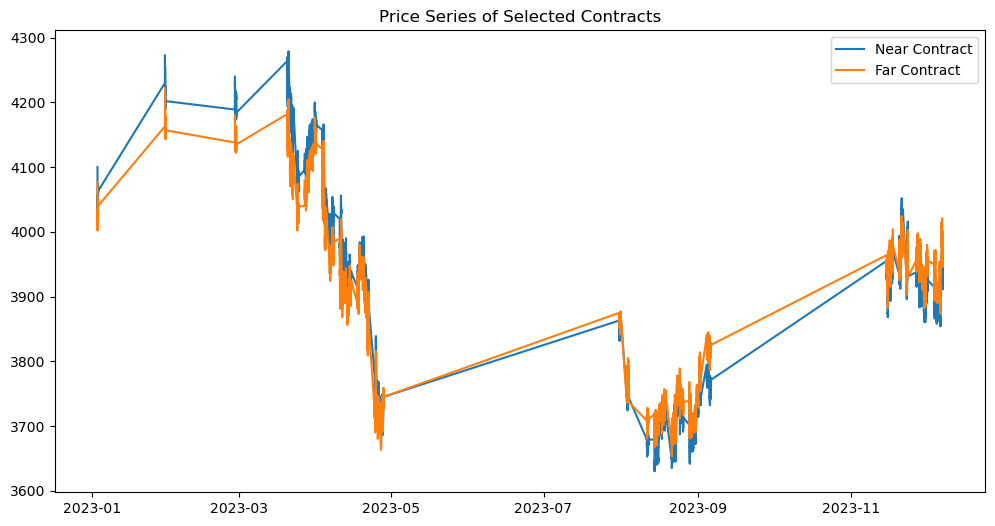

<Axes: title={'center': 'Spread Series'}>

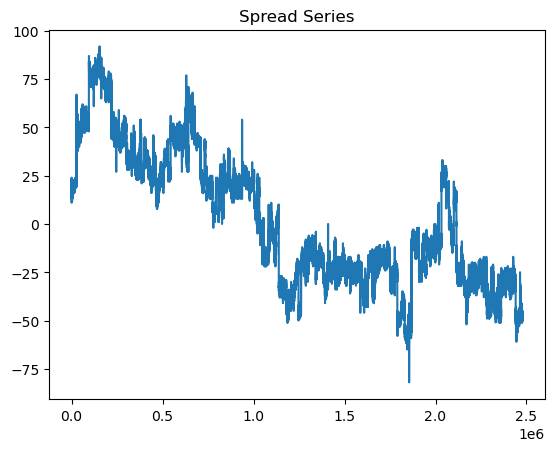

In [26]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(filtered_ticks['timestamp'], filtered_ticks['near_price'], label='Near Contract')
plt.plot(filtered_ticks['timestamp'], filtered_ticks['far_price'], label='Far Contract')
plt.title('Price Series of Selected Contracts')
plt.legend()
plt.show()


spread = filtered_ticks['near_price'] - filtered_ticks['far_price']
spread.plot(title='Spread Series')

In [27]:
print("spread：\n", spread.head())
print("len：", len(spread.dropna()))


 1    23.0
2    15.0
3    11.0
4    11.0
5    13.0
dtype: float64
len： 2084944


In [30]:
print("NaN:", spread.isna().sum())
print("Inf:", np.isinf(spread).sum())

NaN: 0
Inf: 0


In [ ]:
def chunk_adf(chunk):
    try:
        return adfuller(chunk, maxlag=1, autolag=None)[1]
    except:
        return np.nan
    
chunks = [spread.iloc[i:i+10000] for i in range(0, len(spread), 10000)]

p_values = Parallel(n_jobs=-1)(delayed(chunk_adf)(chunk) for chunk in chunks)
significant_ratio = np.mean(np.array(p_values) < 0.05)

print(f"stable windows: {significant_ratio:.2%}")



stable windows: 94.74%


In [35]:
filtered_ticks.columns

Index(['timestamp', 'near_price', 'Volume_x', 'BidPrice1_x', 'AskPrice1_x',
       'far_price', 'Volume_y', 'BidPrice1_y', 'AskPrice1_y', 'corrected_ts',
       'time', 'date'],
      dtype='object')

In [36]:
valid_pairs.columns

Index(['TradingDay', 'InstrumentID', 'UpdateTime', 'UpdateMillisec',
       'LastPrice', 'Volume', 'BidPrice1', 'BidVolume1', 'AskPrice1',
       'AskVolume1', 'AveragePrice', 'Turnover', 'OpenInterest', 'date',
       'contract', 'expiry', 'days_to_expiry', 'top_contracts',
       'near_contract', 'far_contract', 'near_expiry', 'far_expiry',
       'month_diff', 'timestamp'],
      dtype='object')